<h1 align='center'><b><font color='indianred'></p>Spam Detection</b></h1>


Loading Dataset

In [ ]:
#importing all libraries
import pandas as pd
from pathlib import Path
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install -U nltk -qq
  !pip install -U spacy -qq
  !python -m spacy download en_core_web_sm -qq

  basepath  = '/content/drive/MyDrive/NaturalLanguageprocessingClass'
  sys.path.append('/content/drive/MyDrive/NaturalLanguageprocessingClass/custom_functions_py_files')
else:
  basepath = '/home/richa/Insync/google_drive_richa/NaturalLanguageprocessingClass'
  sys.path.append('/home/richa/Insync/google_drive_richa/NaturalLanguageprocessingClass/custom_functions_py_files')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-26 20:39:59.251051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-26 20:39:59.251208: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-26 20:39:59.251233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot d

In [ ]:
base_folder=Path(basepath)
data_folder=base_folder/'spamdata/archive'
model_folder=base_folder/'models/spamdata_hw3'
custom_fuctions=base_folder/'custom_functions_py_files'

In [ ]:
import custom_preprocessor_mod as cp
from  featurizer import ManualFeatures
from  plot_learning_curve import plot_learning_curve
from featurizer1 import ManualFeatures1

In [ ]:
import chardet
with open(data_folder/'spam.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.7270322499829184, 'language': ''}

In [ ]:
df=pd.read_csv(data_folder/'spam.csv',encoding= 'Windows-1252')
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [ ]:
df.shape

(5572, 5)

In [ ]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
df['Unnamed: 2'].unique()

array([nan, ' PO Box 5249',
       ' the person is definitely special for u..... But if the person is so special',
       ' HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE JEN XXX\\""',
       ' wanted to say hi. HI!!!\\" Stop? Send STOP to 62468"',
       'this wont even start........ Datz confidence.."', 'GN',
       '.;-):-D"',
       'just been in bedbut mite go 2 thepub l8tr if uwana mt up?loads a luv Jenxxx.\\""',
       ' bt not his girlfrnd... G o o d n i g h t . . .@"',
       ' I\'ll come up"',
       ' don\'t miss ur best life for anything... Gud nyt..."',
       ' just as a shop has to give a guarantee on what they sell. B. G."',
       ' But at d end my love compromised me for everything:-(\\".. Gud mornin:-)"',
       ' the toughest is acting Happy with all unspoken pain inside..\\""',
       ' smoke hella weed\\""', '\\" not \\"what i need to do.\\""',
       'JUST GOT PAYED2DAY & I HAVBEEN GIVEN Aå£50 PAY RISE 4MY WORK & HAVEBEEN MADE PRESCHOOLCO-ORDINATOR 2I AM FEELINGOOD

In [ ]:
df['Unnamed: 3'].unique()

array([nan, ' MK17 92H. 450Ppw 16"', ' why to miss them', 'GE',
       'U NO THECD ISV.IMPORTANT TOME 4 2MORO\\""',
       'i wil tolerat.bcs ur my someone..... But',
       ' ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\\""',
       'whoever is the KING\\"!... Gud nyt"', ' TX 4 FONIN HON',
       ' \\"OH No! COMPETITION\\". Who knew', 'IåÕL CALL U\\""'],
      dtype=object)

In [ ]:
df['Text of email']=df['v2'].combine_first(df['Unnamed: 2'])
df['Text of email']=df['Text of email'].combine_first(df['Unnamed: 3'])
df['Text of email']=df['Text of email'].combine_first(df['Unnamed: 4'])

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,Text of email
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.drop(columns=['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

In [ ]:
df.head()

,v1,Text of email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.columns=['Label','Message']

In [ ]:
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
ham=df[df['Label']=='ham'].shape[0]*100/df.shape[0]
print(f'percentage of ham messages is {ham}')
spam=df[df['Label']=='spam'].shape[0]*100/df.shape[0]
print(f'percentage of spam messages is {spam}')

percentage of ham messages is 86.59368269921033
percentage of spam messages is 13.406317300789663


In [ ]:
df['Label']=df['Label'].replace({'spam':1,'ham':0}).astype(float)


In [ ]:
df.head()

,Label,Message
0,0.0,"Go until jurong point, crazy.. Available only ..."
1,0.0,Ok lar... Joking wif u oni...
2,1.0,Free entry in 2 a wkly comp to win FA Cup fina...
3,0.0,U dun say so early hor... U c already then say...
4,0.0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
x=df.Message
y=df.Label
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,stratify=y,random_state=1)

In [ ]:
train=pd.concat([x_train,y_train],ignore_index=True,axis=1)
train.columns=['Message','Label']

In [ ]:
train.head

<bound method NDFrame.head of                                                 Message  Label
2357  Okay same with me. Well thanks for the clarifi...    0.0
5568              Will Ì_ b going to esplanade fr home?    0.0
2985  Reply to win å£100 weekly! What professional s...    1.0
951                            Shb b ok lor... Thanx...    0.0
647   PRIVATE! Your 2003 Account Statement for shows...    1.0
...                                                 ...    ...
4771  Hi, Mobile no.  &lt;#&gt;  has added you in th...    0.0
1225  sir, you will receive the account no another 1...    0.0
1196  What he said is not the matter. My mind saying...    0.0
1769  Ha... Both of us doing e same thing. But i got...    0.0
3281  Hey you around? I've got enough for a half + t...    0.0

[4457 rows x 2 columns]>

In [ ]:
train.columns

Index(['Message', 'Label'], dtype='object')

In [ ]:
test=pd.concat([x_test,y_test],ignore_index=True,axis=1)
test.columns=['Message','Label']

In [ ]:
train_smaller = train.sample(frac=0.1, replace=True, random_state=1)
test_smaller=test.sample(frac=0.1,replace =True,random_state=1)

In [ ]:
x_train_s=train_smaller.Message.values
y_train_s=train_smaller.Label.values
x_test_s=test_smaller.Message.values
y_test_s=test_smaller.Label.values

In [ ]:
x_train.head()

2357    Okay same with me. Well thanks for the clarifi...
5568                Will Ì_ b going to esplanade fr home?
2985    Reply to win å£100 weekly! What professional s...
951                              Shb b ok lor... Thanx...
647     PRIVATE! Your 2003 Account Statement for shows...
Name: Message, dtype: object

As this data is highly imbalanced. I will consider spam as positive class. In spam detection i can not afford type 1 error that is if i label a non spam mail as spam mail a person may miss important mail. Also type 2 error false negative can cause spam in inbox and fraud. so i will use f1 as my evaluation metrics as both false positive and false negative should be given same importance in prediction.

1. Sparse Ebedding

In [ ]:
X_train_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(x_train_s)

In [ ]:
X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(x_test_s)

In [ ]:
file_X_train_cleaned_sparse_embed = data_folder / 'x_train_cleaned_sparse_embed.pkl'

In [ ]:
joblib.dump(X_train_cleaned, file_X_train_cleaned_sparse_embed)

['/content/drive/MyDrive/NaturalLanguageprocessingClass/spamdata/archive/x_train_cleaned_sparse_embed.pkl']

In [ ]:
file_X_test_cleaned_sparse_embed = data_folder / 'x_test_cleaned_sparse_embed.pkl'

In [ ]:
joblib.dump(X_test_cleaned, file_X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/NaturalLanguageprocessingClass/spamdata/archive/x_test_cleaned_sparse_embed.pkl']

In [ ]:
from xgboost import XGBClassifier
classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
    ('classifier', XGBClassifier()) ])

In [ ]:
param_grid_classifier_1 = {'vectorizer__max_features': [100, 500, 1000, 2000, 5000],
                             'classifier__eta':[.001,.01,.1,1,10,100],'classifier__max_depth':[10,40,80,150,200],'classifier__scale_pos_weight':[10,20,30,40,50],'classifier':[XGBClassifier()]
                           }

In [ ]:
grid_classifier_1 = GridSearchCV(estimator=classifier_1, param_grid=param_grid_classifier_1, cv = 3,scoring = 'f1')
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)
grid_classifier_1.fit(X_train_cleaned_sparse_embed, y_train_s)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier', XGBClassifier())]),
             param_grid={'classifier': [XGBClassifier(eta=0.001, max_depth=10,
                                                      scale_pos_weight=20)],
                         'classifier__eta': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__max_depth': [10, 40, 80, 150, 200],
                         'classifier__scale_pos_weight': [10, 20, 30, 40, 50],
                         'vectorizer__max_features': [100, 500, 1000, 2000,
                                                      5000]},
             scoring='f1')

In [ ]:
print(f'Best cross-validation score: {grid_classifier_1.best_score_}')
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.750137717579578

Best parameters:  {'classifier': XGBClassifier(eta=0.001, max_depth=10, scale_pos_weight=20), 'classifier__eta': 0.001, 'classifier__max_depth': 10, 'classifier__scale_pos_weight': 20, 'vectorizer__max_features': 2000}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=2000, token_pattern='[\\S]+')),
                ('classifier',
                 XGBClassifier(eta=0.001, max_depth=10, scale_pos_weight=20))])


In [ ]:
file_best_estimator_spam_sparse = model_folder / 'pipeline1_spam_sparse_best_estimator.pkl'
file_complete_grid_spam_sparse= model_folder / 'pipeline1_spam_sparse_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_1.best_estimator_, file_best_estimator_spam_sparse)
joblib.dump(grid_classifier_1, file_complete_grid_spam_sparse)

['/content/drive/MyDrive/NaturalLanguageprocessingClass/models/spamdata_hw3/pipeline1_spam_sparse_complete_grid.pkl']

In [ ]:
# load the saved model
best_estimator_pipeline1_spam_sparse = joblib.load(file_best_estimator_spam_sparse)
complete_grid_pipeline1_spam_sparse = joblib.load(file_complete_grid_spam_sparse)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

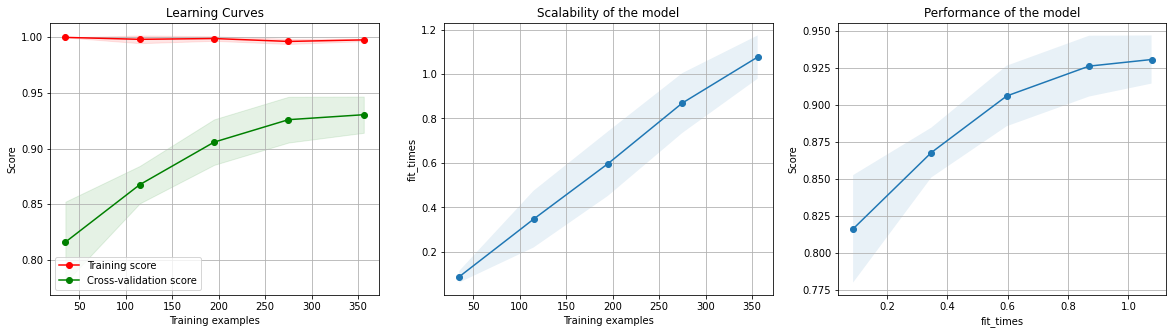

In [ ]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline1_spam_sparse, 'Learning Curves',
                    X_train_cleaned_sparse_embed, y_train_s, n_jobs=-1)

In [ ]:
# let's check the train scores
print(best_estimator_pipeline1_spam_sparse.score(X_train_cleaned_sparse_embed, y_train_s))

# let's check the cross validation score
print(complete_grid_pipeline1_spam_sparse.best_score_)

1.0
0.750137717579578


In [ ]:
# Final Pipeline
def final_pipeline(text):
    # X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_spam_sparse)
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions

In [ ]:
y_test_pred = final_pipeline(x_test_s)

In [ ]:
print('\nTest set classification report:\n\n', 
      classification_report(y_test_s, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98        94
         1.0       0.94      0.89      0.91        18

    accuracy                           0.97       112
   macro avg       0.96      0.94      0.95       112
weighted avg       0.97      0.97      0.97       112



2) Feature Engineering
In this case we will extract following features and use these as the input to our xgboost

number of words

number of characters

number of characters without space

average word length

number of digits

number of numbers

number of nouns or propernouns

number of aux

number of verbs

number of adjectives

number of ner (entiites)

count of money

count of exclamation

In [ ]:
import spacy
from spacy.matcher import Matcher
nlp=spacy.load('en_core_web_sm')

In [ ]:
file_X_train_cleaned_sparse_embed = data_folder / 'x_train_cleaned_sparse_embed.pkl'
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)

In [ ]:
featurizer = ManualFeatures1(spacy_model='en_core_web_sm')

In [ ]:
X_train_features, feature_names = featurizer.fit_transform(X_train_cleaned_sparse_embed)

In [ ]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'exclamation_count',
 'money_count',
 'ner']

In [ ]:
from xgboost import XGBClassifier
classifier_2 = Pipeline([
    ('classifier',XGBClassifier() ),
                        ])

In [ ]:
param_grid_classifier_2 = {'classifier__eta':[.001,.01,.1,1,10,100],'classifier__max_depth':[10,40,80,150,200],'classifier__scale_pos_weight':[10,20,30,40,50],'classifier':[XGBClassifier()]
                           }

In [ ]:
grid_classifier_2 = GridSearchCV(estimator=classifier_2,
                                 param_grid=param_grid_classifier_2,scoring='f1',
                                 cv=3)

In [ ]:
grid_classifier_2.fit(X_train_features, y_train_s)

GridSearchCV(cv=3, estimator=Pipeline(steps=[('classifier', XGBClassifier())]),
             param_grid={'classifier': [XGBClassifier(eta=0.001, max_depth=10,
                                                      scale_pos_weight=10)],
                         'classifier__eta': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__max_depth': [10, 40, 80, 150, 200],
                         'classifier__scale_pos_weight': [10, 20, 30, 40, 50]},
             scoring='f1')

In [ ]:
print(f'Best cross-validation score: {grid_classifier_2.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest estimator: ", grid_classifier_2.best_estimator_)

Best cross-validation score: 0.90

Best parameters:  {'classifier': XGBClassifier(eta=0.001, max_depth=10, scale_pos_weight=10), 'classifier__eta': 0.001, 'classifier__max_depth': 10, 'classifier__scale_pos_weight': 10}

Best estimator:  Pipeline(steps=[('classifier',
                 XGBClassifier(eta=0.001, max_depth=10, scale_pos_weight=10))])


In [ ]:
file_best_estimator_pipeline2_spam_fe = model_folder / 'pipeline2_spam_fe_best_estimator.pkl'
file_complete_grid_pipeline2_spam_fe = model_folder / 'pipeline2_spam_fe_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_2.best_estimator_, file_best_estimator_pipeline2_spam_fe)
joblib.dump(grid_classifier_2, file_complete_grid_pipeline2_spam_fe)

['/content/drive/MyDrive/NaturalLanguageprocessingClass/models/spamdata_hw3/pipeline2_spam_fe_complete_grid.pkl']

In [ ]:
# load the saved model
best_estimator_pipeline2_spam_fe = joblib.load(file_best_estimator_pipeline2_spam_fe)
complete_grid_pipeline2_spam_fe = joblib.load(file_complete_grid_pipeline2_spam_fe)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

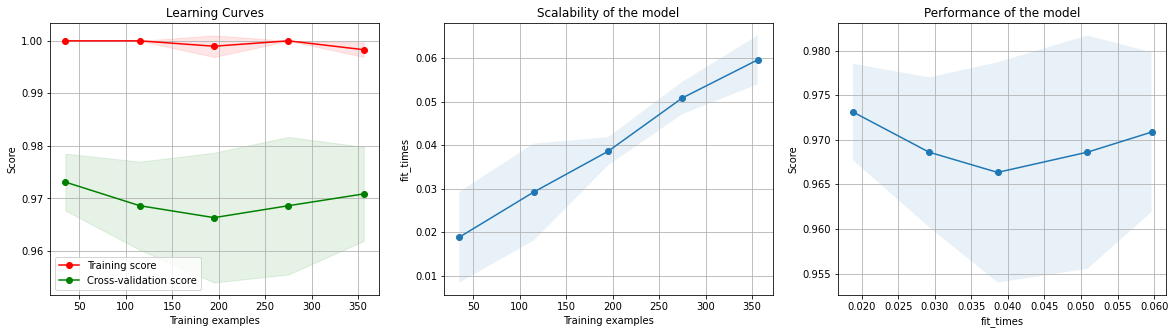

In [ ]:
plot_learning_curve(best_estimator_pipeline2_spam_fe, 'Learning Curves',
                    X_train_features, y_train_s, n_jobs=-1)

In [ ]:
print(best_estimator_pipeline2_spam_fe.score(X_train_features, y_train_s))

# let's check the cross validation score
print(complete_grid_pipeline2_spam_fe.best_score_)

0.9977578475336323
0.8966242488511842


In [ ]:
def final_pipeline(text):
    features, feature_names = featurizer.fit_transform(text)
    best_estimator_pipeline2_spam_fe = joblib.load(file_best_estimator_pipeline2_spam_fe)
    predictions = best_estimator_pipeline2_spam_fe.predict(features)
    return predictions

In [ ]:
y_test_pred = final_pipeline(x_test_s)

In [ ]:
print('\nTest set classification report:\n\n', 
      classification_report(y_test_s, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        94
         1.0       0.94      0.83      0.88        18

    accuracy                           0.96       112
   macro avg       0.95      0.91      0.93       112
weighted avg       0.96      0.96      0.96       112



3) Mixed 

In [ ]:
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)

In [ ]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis =1)

In [ ]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [ ]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])

In [ ]:
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )

In [ ]:
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', XGBClassifier()),
                        ])

In [ ]:
classifier_3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

In [ ]:
param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000], 'classifier__eta':[.001,.01,.1,1,10,100],'classifier__max_depth':[10,40,80,150,200],'classifier__scale_pos_weight':[10,20,30,40,50],'classifier':[XGBClassifier()]
                           
                          }

In [ ]:
grid_classifier_3 = GridSearchCV(estimator=classifier_3, 
                                 param_grid=param_grid_classifier_3,
                                 cv=3)

In [ ]:
grid_classifier_3.fit(X_train_final, y_train_s)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5))]),
                                                                         'cleaned_text')])),
                                       ('classifier', XGBClassifier())]),
             param_grid={'classifier': [XGBClassifier(eta=0.001, max_depth=10,
                                                      scale_pos_weight=20)],
                         'classifier__eta': [0.001, 0.01, 0.1, 1, 10, 100],
          

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'classifier': XGBClassifier(eta=0.001, max_depth=10, scale_pos_weight=20), 'classifier__eta': 0.001, 'classifier__max_depth': 10, 'classifier__scale_pos_weight': 20, 'combined_features__tfidf__tfidf__max_features': 500}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  'cleaned_text')])),
                ('classifier',
                 XGBClassifier(eta=0.001, max_depth=10, scale_pos_weight=20))])


In [ ]:
file_best_estimator_pipeline3_spam_mixed = model_folder / 'pipeline3_spam_mixed_best_estimator.pkl'
file_complete_grid_pipeline3_spam_mixed = model_folder / 'pipeline3_spam_mixed_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_3.best_estimator_, file_best_estimator_pipeline3_spam_mixed)
joblib.dump(grid_classifier_3, file_complete_grid_pipeline3_spam_mixed)

['/content/drive/MyDrive/NaturalLanguageprocessingClass/models/spamdata_hw3/pipeline3_spam_mixed_complete_grid.pkl']

In [ ]:
best_estimator_pipeline3_spam_mixed = joblib.load(file_best_estimator_pipeline3_spam_mixed)
complete_grid_pipeline3_spam_mixed = joblib.load(file_complete_grid_pipeline3_spam_mixed)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

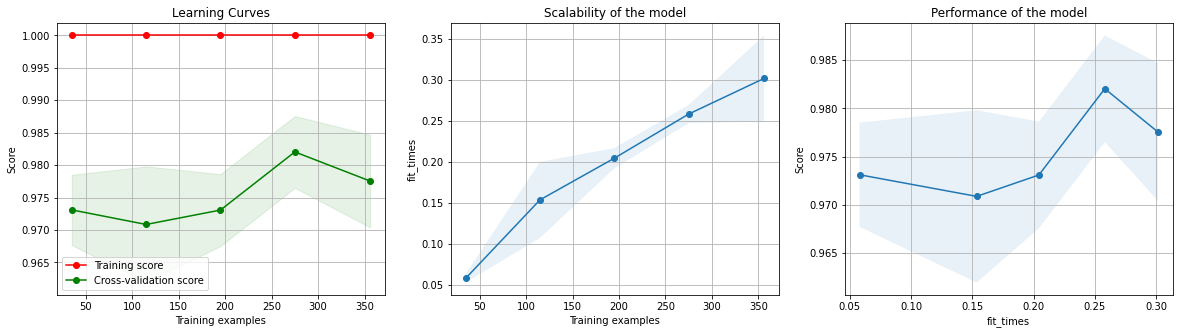

In [ ]:
plot_learning_curve(best_estimator_pipeline3_spam_mixed, 'Learning Curves',
                    X_train_final, y_train_s, n_jobs=-1)

In [ ]:
# let's check the train scores
print(best_estimator_pipeline3_spam_mixed.score(X_train_final, y_train_s))

# let's check the cross validation score
print(complete_grid_pipeline3_spam_mixed.best_score_)

0.9977578475336323
0.9798204244512969


In [ ]:
def final_pipeline(text):
    # X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    X_features, feature_names = featurizer.fit_transform(text)
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_spam_mixed = joblib.load(file_best_estimator_pipeline3_spam_mixed)
    predictions = best_estimator_pipeline3_spam_mixed.predict(X_final)
    return predictions

In [ ]:
y_test_pred = final_pipeline(x_test_s)

In [ ]:
print('\nTest set classification report:\n\n', classification_report(y_test_s, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        94
         1.0       0.94      0.83      0.88        18

    accuracy                           0.96       112
   macro avg       0.95      0.91      0.93       112
weighted avg       0.96      0.96      0.96       112

